In [1]:
from multiprocessing.pool import ThreadPool
from tqdm import tqdm
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import calendar

def dados_ana(list_station, data_type, threads=10):
        if type(list_station) is not list:
            list_station = [list_station]
        data_types = {'3': ['Vazao{:02}'], '2': ['Chuva{:02}'], '1': ['Cota{:02}']}

        def __call_request(station):
            params = {'codEstacao': str(station), 'dataInicio': '', 'dataFim': '', 'tipoDados': data_type, 'nivelConsistencia': ''}
            
            response = requests.get('http://telemetriaws1.ana.gov.br/ServiceANA.asmx/HidroSerieHistorica', params,
                                        timeout=120.0)

            tree = ET.ElementTree(ET.fromstring(response.content))
            root = tree.getroot()
            
            df = []
            for month in root.iter('SerieHistorica'):
                code = month.find('EstacaoCodigo').text
                code = f'{int(code):08}'
                consist = int(month.find('NivelConsistencia').text)
                date = pd.to_datetime(month.find('DataHora').text, dayfirst=False)
                date = pd.Timestamp(date.year, date.month, 1, 0)
                last_day = calendar.monthrange(date.year, date.month)[1]
                month_dates = pd.date_range(date, periods=last_day, freq='D')
                data = []
                list_consist = []
                for i in range(last_day):
                    value = data_types[params['tipoDados']][0].format(i + 1)
                    try:
                        data.append(float(month.find(value).text))
                        list_consist.append(consist)
                    except TypeError:
                        data.append(month.find(value).text)
                        list_consist.append(consist)
                    except AttributeError:
                        data.append(None)
                        list_consist.append(consist)
                index_multi = list(zip(month_dates, list_consist))
                index_multi = pd.MultiIndex.from_tuples(index_multi, names=["Date", "Consistence"])
                df.append(pd.DataFrame({code: data}, index=index_multi))
            if (len(df)) == 0:
                return pd.DataFrame()
            df = pd.concat(df)
            df = df.sort_index()
            
            drop_index = df.reset_index(level=1, drop=True).index.duplicated(keep='last')
            df = df[~drop_index]
            df = df.reset_index(level=1, drop=True)
            
            series = df[code]
            date_index = pd.date_range(series.index[0], series.index[-1], freq='D')
            series = series.reindex(date_index)
            return series

        if len(list_station) < threads:
            threads = len(list_station)

        with ThreadPool(threads) as pool:
            responses = list(tqdm(pool.imap(__call_request, list_station), total=len(list_station)))
        responses = [response for response in responses if not response.empty]
        data_stations = pd.concat(responses, axis=1)
        date_index = pd.date_range(data_stations.index[0], data_stations.index[-1], freq='D')
        data_stations = data_stations.reindex(date_index)
        return data_stations

estacoes= ["17050001", "17050000"]
df = dados_ana(estacoes, '3') #3: vazao, 2: precipitacao, 1: cota
df

  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\PersioPuertasGarciaL\AppData\Local\Temp\ipykernel_10980\2881795087.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(df)
100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


,17050001,17050000
1927-12-01,NaN,NaN
1927-12-02,NaN,NaN
1927-12-03,NaN,NaN
1927-12-04,NaN,NaN
1927-12-05,NaN,NaN
...,...,...
2025-02-24,175127.0,NaN
2025-02-25,176297.0,NaN
2025-02-26,177469.0,NaN
2025-02-27,178644.0,NaN


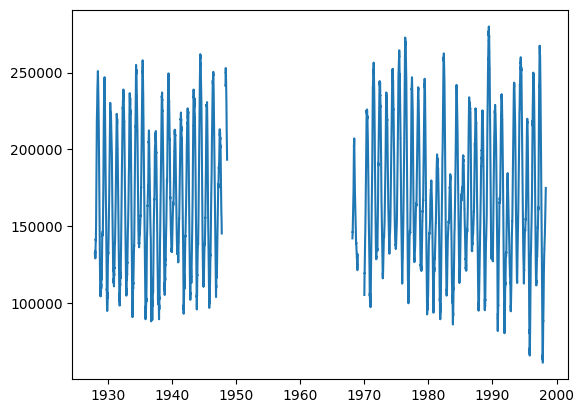

In [2]:
import matplotlib.pyplot as plt
plt.plot(df['17050000'])